In [2]:
%cd /home/orion/Desktop/Prog/Lascon/Ca2Temporal-deconvolution/Model/BahlEtAl2012/channels/
!nrnivmodl
%cd /home/orion/Desktop/Prog/Lascon/Ca2Temporal-deconvolution/Model/BahlEtAl2012/init_models_with_ca/
#!h.nrn_load_dll("./x86_64/.libs/libnrnmech.so")


/home/orion/Desktop/Prog/Lascon/Ca2Temporal-deconvolution/Model/BahlEtAl2012/channels
/home/orion/anaconda3/envs/Neuron/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/orion/Desktop/Prog/Lascon/Ca2Temporal-deconvolution/Model/BahlEtAl2012/channels
Mod files: "./cad.mod" "./h.mod" "./IKM.mod" "./kca.mod" "./kfast.mod" "./kslow.mod" "./nap.mod" "./nat.mod" "./SlowCa.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special
/home/orion/Desktop/Prog/Lascon/Ca2Temporal-deconvolution/Model/BahlEtAl2012/init_models_with_ca


NEURON: unable to open font "*helvetica-medium-r-normal*--14*", using "fixed"


	1 
	1 
	1 
	1 
Model loaded successfully.
Loaded Soma gbar_nat: 236.616175 (Expected ~284.5)
Loaded Global Rm_axosomatic: 20587.734598


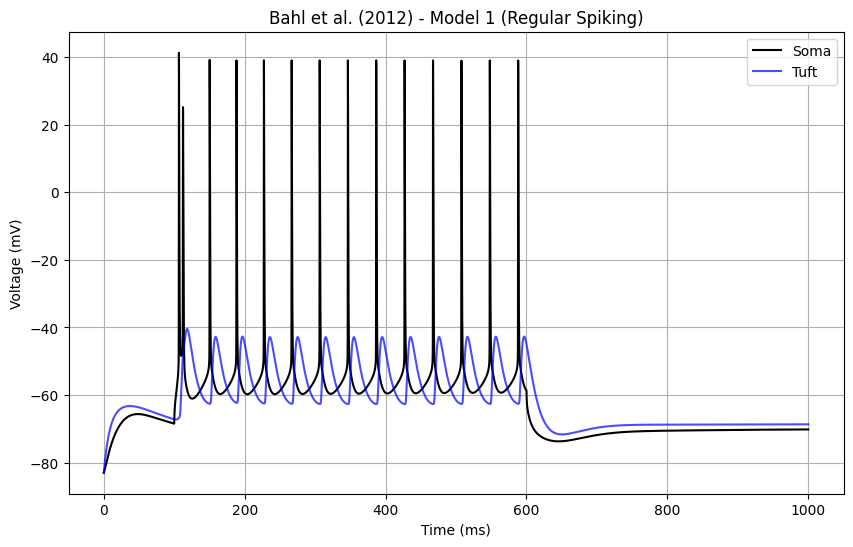

In [3]:
import matplotlib.pyplot as plt
from neuron import h, gui
import numpy as np

# -------------------------------------------------------------------------
# 1. Load the Model using the HOC files
# -------------------------------------------------------------------------
# Note: 'init_model1.hoc' attempts to load "../reduced_model.hoc".
# Ensure your folder structure matches this, or edit init_model1.hoc 
# to remove "../" if all files are in the same directory.

try:
    h.load_file("/home/orion/Desktop/Prog/Lascon/Ca2Temporal-deconvolution/Model/BahlEtAl2012/init_models_with_ca/init_model2.hoc")
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading HOC file: {e}")
    print("Tip: Check that 'reduced_model.hoc' is in the location expected by 'init_model1.hoc'")

# -------------------------------------------------------------------------
# 2. Access HOC Components from Python
# -------------------------------------------------------------------------
# The HOC files define sections at the top level. We can access them via 'h'.
soma = h.soma
apical = h.apical
tuft = h.tuft

# Verify the parameters were loaded from init_model1.hoc 
print(f"Loaded Soma gbar_nat: {soma.gbar_nat} (Expected ~284.5)")
print(f"Loaded Global Rm_axosomatic: {h.Rm_axosomatic}")

# -------------------------------------------------------------------------
# 3. Setup Simulation (Stimulus & Recording)
# -------------------------------------------------------------------------
# Create a current clamp at the soma
stim = h.IClamp(soma(0.5))
stim.delay = 100  # ms
stim.dur = 500    # ms
stim.amp = 0.65    # nA (elicits regular spiking)

# Record time and voltage
t_vec = h.Vector().record(h._ref_t)
v_soma = h.Vector().record(soma(0.5)._ref_v)
v_tuft = h.Vector().record(tuft(0.5)._ref_v)
cai_tuft = h.Vector().record(tuft(0.5)._ref_cai)

# -------------------------------------------------------------------------
# 4. Run Simulation
# -------------------------------------------------------------------------
h.tstop = 1000
h.v_init = -83  # Match the e_pas set in init_model1.hoc 
h.run()

# -------------------------------------------------------------------------
# 5. Plot Results
# -------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(t_vec, v_soma, label='Soma', color='k')
plt.plot(t_vec, v_tuft, label='Tuft', color='b', alpha=0.7)
plt.title("Bahl et al. (2012) - Model 1 (Regular Spiking)")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.legend()
plt.grid(True)
plt.show()

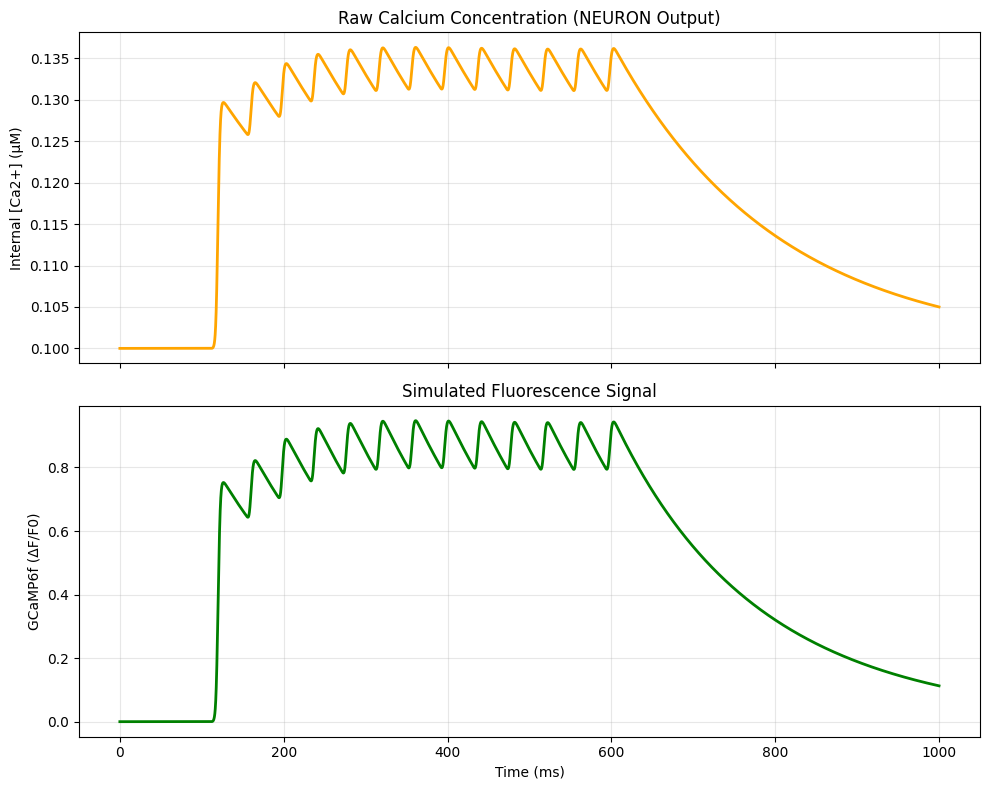

In [4]:
def calculate_dF_F(cai_array, Kd=375e-6, n=2.3):
    """
    Converts Calcium Concentration (mM) to dF/F using the Hill Equation 
    for GCaMP6f.
    
    Parameters:
    - cai_array: Numpy array of Calcium concentrations in mM
    - Kd: Dissociation constant (default 375 nM for GCaMP6f)
    - n: Hill coefficient (default 2.3 for GCaMP6f)
    
    Returns:
    - dF_F: Array of normalized fluorescence change
    """
    # 1. Calculate absolute fluorescence (arbitrary units) based on binding
    # F_t = [Ca]^n / ([Ca]^n + Kd^n)
    # We assume F_min is negligible for the dF calculation or part of baseline
    
    F_t = (np.array(cai_array)**n) / (np.array(cai_array)**n + Kd**n)
    
    # 2. Calculate baseline fluorescence (F0)
    # We assume the resting calcium (first few points) sets the baseline
    F0 = np.mean(F_t[:100]) # Average of first 100 points
    
    # 3. Calculate dF/F
    dF_F = (F_t - F0) / F0
    
    return dF_F

# --- Processing the Data ---

# 1. Convert NEURON Vector to Numpy Array
cai_data = np.array(cai_tuft)
time_data = np.array(t_vec)

# 2. Calculate Fluorescence
dF_trace = calculate_dF_F(cai_data)

# --- Plotting ---

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot 1: Raw Internal Calcium (mM)
ax1.plot(time_data, cai_data * 1000, color='orange', linewidth=2) # Convert to uM for readability
ax1.set_ylabel('Internal [Ca2+] (µM)')
ax1.set_title('Raw Calcium Concentration (NEURON Output)')
ax1.grid(True, alpha=0.3)

# Plot 2: Simulated GCaMP6f Fluorescence (dF/F)
ax2.plot(time_data, dF_trace, color='green', linewidth=2)
ax2.set_ylabel('GCaMP6f (ΔF/F0)')
ax2.set_xlabel('Time (ms)')
ax2.set_title('Simulated Fluorescence Signal')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
def apply_sensor_kinetics(signal, dt, tau_rise=1, tau_decay=140):
    from scipy.signal import convolve
    t_kernel = np.arange(0, 500, dt) # 500ms kernel
    # Double exponential kernel
    kernel = (1 - np.exp(-t_kernel/tau_rise)) * np.exp(-t_kernel/tau_decay)
    kernel = kernel / np.sum(kernel) # Normalize
    return convolve(signal, kernel, mode='full')[:len(signal)]

# Usage:
dF_realistic = apply_sensor_kinetics(dF_trace, h.dt)

In [9]:
#Try to add calcium in the soma
soma.insert('cad')
soma.insert('sca')
soma.gbar_sca = 0.0001

In [19]:
stim=h.IClamp(soma(0.5))
stim.delay = 100  # ms
stim.dur = 500    # ms
stim.amp = 0.65    # nA (elicits regular spiking)

t_vec = h.Vector().record(h._ref_t)
v_soma = h.Vector().record(soma(0.5)._ref_v)
v_tuft = h.Vector().record(tuft(0.5)._ref_v)
cai_soma = h.Vector().record(soma(0.35)._ref_cai)
cai_tuft = h.Vector().record(tuft(0.5)._ref_cai)
h.tstop = 10000
h.v_init = -83  # Match the e_pas set in init_model1.hoc 
h.run()


0.0

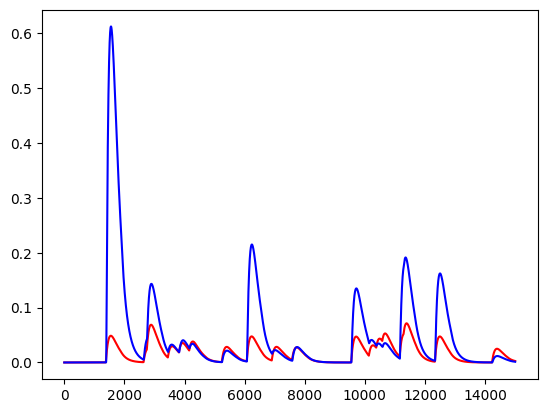

In [56]:
plt.plot(t_vec,apply_sensor_kinetics(calculate_dF_F(cai_soma),h.dt),c='r')
plt.plot(t_vec,apply_sensor_kinetics(calculate_dF_F(cai_tuft),h.dt),c='b')
plt.xscale('linear')
plt.yscale('linear')

Changed dt
Rendering frames...


  0%|          | 0/6401 [00:00<?, ?it/s]/tmp/ipykernel_5776/399014906.py:138: RuntimeWarning: invalid value encountered in power
  f_vals = (cai_t**n) / (cai_t**n + Kd**n)
100%|██████████| 6401/6401 [00:14<00:00, 438.53it/s]


Saved 'simulated_neuron_caiman.tif'. Use this file in CaImAn.


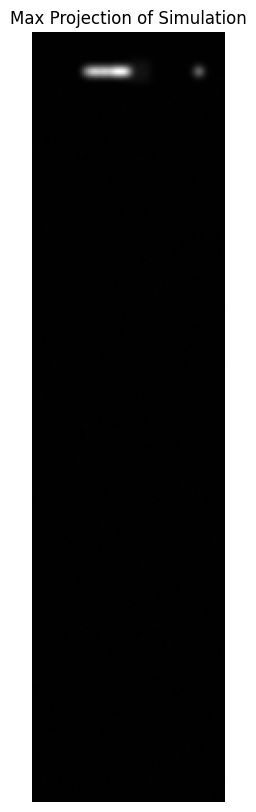

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h
from scipy.ndimage import gaussian_filter
import tifffile
from tqdm import tqdm # For progress bars

# IMPORTANT: The default Bahl model only has Calcium in the TUFT.
# For a cool video, let's add calcium dynamics to the whole apical tree.
for sec in h.apicaltree_list: # Accessing the list defined in reduced_geometry
    if not h.ismembrane('cad', sec=sec):
        sec.insert('cad')
        sec.insert('sca') # Slow Ca
        sec.insert('kca') # Ca-dependent K
        # Set basic params similar to tuft
        sec.gbar_sca = h.tuft.gbar_sca
        sec.gbar_kca = h.tuft.gbar_kca

# Force a 2D layout so we can "photograph" it
h.define_shape() 
# Manually adjust rotation if needed (Bahl model is often a straight line)
# This rotates it so it stands upright in the Y-axis

# ---------------------------------------------------------
# 2. The Spatial Recorder Class
# ---------------------------------------------------------
class VirtualMicroscope:
    def __init__(self, section_list):
        self.segments = []
        self.coords = [] # (x, y) center of each segment
        self.diams = []  # diameter of each segment
        self.recs = []   # list of vectors
        
        # 1. Catalog all segments and their 2D positions
        for sec in section_list:
            # Get 3D coords of section start and end
            x0 = sec.x3d(0)
            y0 = sec.y3d(0)
            x1 = sec.x3d(sec.n3d()-1)
            y1 = sec.y3d(sec.n3d()-1)
            
            for seg in sec:
                self.segments.append(seg)
                self.diams.append(seg.diam)
                
                # Linear interpolation to find segment center
                # (Simple approximation for the Bahl reduced model)
                rel_pos = seg.x
                cx = x0 + (x1-x0)*rel_pos
                cy = y0 + (y1-y0)*rel_pos
                self.coords.append([cx, cy])
                
                # Prepare recording
                # If Ca dynamics exist, record cai. Else record 0.
                if h.ismembrane('cad', sec=seg.sec):
                    self.recs.append(h.Vector().record(seg._ref_cai))
                else:
                    # Dummy vector for segments without calcium (soma/axon in base model)
                    self.recs.append(h.Vector().record(seg._ref_v)) # Temp placeholder     

        self.coords = np.array(self.coords)
        self.diams = np.array(self.diams)

    def get_data_matrix(self):
        # Convert NEURON vectors to a generic numpy matrix (Time x Segments)
        data = np.array([np.array(r) for r in self.recs]) # Shape: (Segments, Time)
        return data.T # Shape: (Time, Segments)

# Initialize Recorder for all apical sections
microscope = VirtualMicroscope([s for s in h.allsec()])

# ---------------------------------------------------------
# 3. Run Simulation
# ---------------------------------------------------------
stim = h.IClamp(h.soma(0.5))
stim.delay = 100
stim.dur = 500
stim.amp = 0.8 # Strong enough to light up dendrites

h.dt = 1.5 # Use 1ms steps for video (imaging usually < 30Hz, so 1ms is fine)
h.tstop = 800
h.v_init = -83
h.run()

# ---------------------------------------------------------
# 4. Generate the "Video"
# ---------------------------------------------------------
def render_frame(cai_values, coords, diams, resolution=(512, 128), scale=1.0):
    """
    Rasterizes segments onto a pixel grid.
    resolution: (Height, Width)
    scale: pixels per micron
    """
    H, W = resolution
    frame = np.zeros((H, W))
    
    # Center the neuron in the frame
    center_x = W // 2
    offset_y = 20 # Start near bottom
    
    for i, (x_um, y_um) in enumerate(coords):
        val = cai_values[i]
        d_um = diams[i]
        
        # Convert microns to pixels
        px = int(center_x + x_um * scale)
        py = int(offset_y + y_um * scale)
        radius = max(1, int((d_um * scale) / 2))
        
        # Draw "Circle" for segment (Simple Rasterization)
        # In a real microscope, this is a convolution, but we do that later globally
        y_min, y_max = max(0, py-radius), min(H, py+radius+1)
        x_min, x_max = max(0, px-radius), min(W, px+radius+1)
        
        if val > 0: # Only draw if there is signal
            frame[y_min:y_max, x_min:x_max] += val

    return frame

# Pipeline Parameters
Kd = 375e-6 # mM
n = 2.3
raw_data = microscope.get_data_matrix() # (Time, Segments)

# Video settings
video_stack = []
res = (400, 100) # Tall, narrow video for a single neuron
scale = 0.5 # 0.5 pixels per micron

print("Rendering frames...")
for t in tqdm(range(0, raw_data.shape[0], 5)): # Skip frames to match ~30Hz (assuming dt=1)
    
    # 1. Get Calcium at this time step
    cai_t = raw_data[t, :]
    
    # 2. Apply Hill Equation (Concentration -> Fluorescence)
    # Only apply to segments that actually had Calcium recorded (checked by magnitude)
    f_vals = (cai_t**n) / (cai_t**n + Kd**n) + 10e-9
    
    # 3. Rasterize
    img = render_frame(f_vals, microscope.coords, microscope.diams, resolution=res, scale=scale)
    
    # 4. Apply Optics (Point Spread Function)
    # Microscopes blur light. Sigma=2 pixels simulates this.
    img_blurred = gaussian_filter(img, sigma=2)
    
    # 5. Add Sensor Noise
    # Poisson noise (photon shot noise) + Gaussian (electronic noise)
    noise = np.random.normal(0, 0.005, img_blurred.shape) # Gaussian background
    img_noisy = img_blurred + noise
    
    video_stack.append(img_noisy.astype(np.float32))

video_stack = np.array(video_stack)

# ---------------------------------------------------------
# 5. Save and View
# ---------------------------------------------------------
# Save as TIF for CaImAn
tifffile.imwrite('/media/orion/PersonalBs/simulated_neuron_caiman.tif', video_stack)
print("Saved 'simulated_neuron_caiman.tif'. Use this file in CaImAn.")

# Quick Preview
plt.figure(figsize=(4, 10))
plt.imshow(np.max(video_stack, axis=0), cmap='gray') # Max projection
plt.title("Max Projection of Simulation")
plt.axis('off')
plt.show()

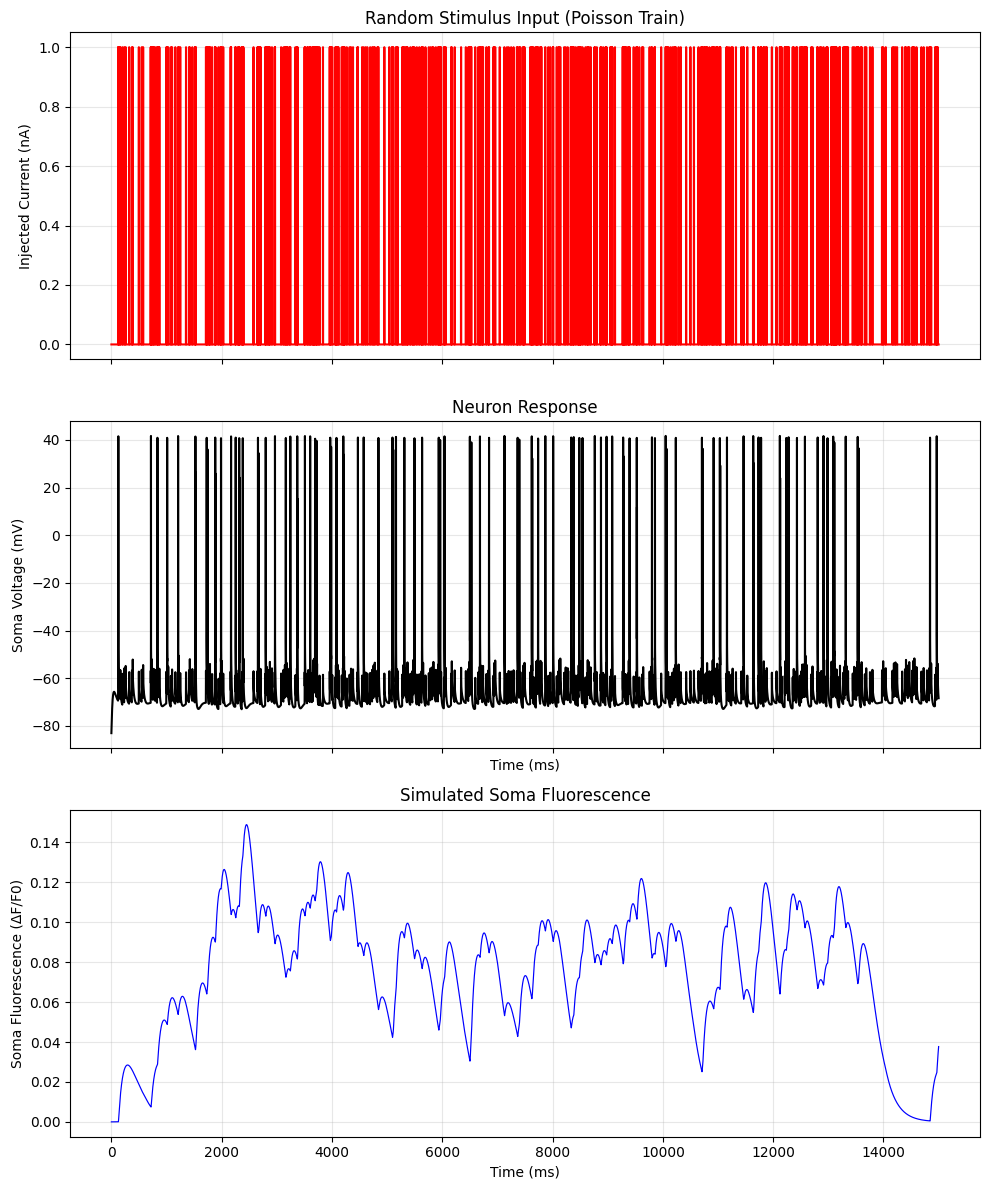

In [79]:
class RandomStimulator:
    def __init__(self, section):
        """
        Attaches a stimulus to the specified section.
        """
        self.stim = h.IClamp(section(0.5))
        self.stim.dur = 1e9 # Set duration to infinite (controlled by vector)
        
        # Vectors to hold the waveform
        self.stim_amp_vec = h.Vector()
        self.stim_time_vec = h.Vector()

    def create_poisson_pulses(self, t_stop, amp, pulse_dur, frequency):
        """
        Generates a train of square pulses with random start times.
        
        Parameters:
        - t_stop (ms): Total simulation time
        - amp (nA): Amplitude of each pulse
        - pulse_dur (ms): Duration of a single pulse
        - frequency (Hz): Average rate of pulses
        """
        # 1. Generate Random Event Times (Poisson Process)
        # Inter-spike intervals are exponentially distributed
        expected_interval_ms = 1000.0 / frequency
        current_time = 0
        start_times = []
        
        while current_time < t_stop:
            # Generate next interval
            isi = np.random.exponential(expected_interval_ms)
            current_time += isi
            if current_time < t_stop:
                start_times.append(current_time)
        
        # 2. Construct the Vector for Playback (Step Function)
        # We need to define pairs of points for sharp vertical lines
        # Time: [t0, start1, start1, end1, end1, start2, start2...]
        # Amp:  [0,  0,      A,      A,    0,    0,      A...]
        
        times = [0]
        amps = [0]
        
        for t_start in start_times:
            t_end = t_start + pulse_dur
            
            # Rise
            times.append(t_start)
            amps.append(0)
            times.append(t_start)
            amps.append(amp)
            
            # Fall
            times.append(t_end)
            amps.append(amp)
            times.append(t_end)
            amps.append(0)
            
        # Ensure it ends at 0
        times.append(t_stop)
        amps.append(0)

        # 3. Load into NEURON Vectors
        self.stim_time_vec = h.Vector(times)
        self.stim_amp_vec = h.Vector(amps)
        
        # 4. Attach playback to the IClamp amp variable
        # The '1' argument allows for continuous play, but our double-points ensure steps
        self.stim_amp_vec.play(self.stim._ref_amp, self.stim_time_vec, 1)

# --- Simulation Setup ---

# 1. Initialize
stim_gen = RandomStimulator(h.soma)

# 2. Configure Random Stimuli
# Example: 0.5 nA pulses, 5ms long, occurring at ~20 Hz
stim_gen.create_poisson_pulses(t_stop=15000, amp=1.0, pulse_dur=2.5, frequency=35)

# 3. Record
t_vec = h.Vector().record(h._ref_t)
v_soma = h.Vector().record(h.soma(0.5)._ref_v)
cai_soma = h.Vector().record(h.soma(0.5)._ref_cai)
i_stim = h.Vector().record(stim_gen.stim._ref_i) # Record the current actually injected

# 4. Run
h.tstop = 15000
h.v_init = -83
h.run()

# --- Plotting ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Stimulus (Current)
ax1.plot(t_vec, i_stim, color='red')
ax1.set_ylabel('Injected Current (nA)')
ax1.set_title('Random Stimulus Input (Poisson Train)')
ax1.grid(True, alpha=0.3)

# Response (Voltage)
ax2.plot(t_vec, v_soma, color='black')
ax2.set_ylabel('Soma Voltage (mV)')
ax2.set_xlabel('Time (ms)')
ax2.set_title('Neuron Response')
ax2.grid(True, alpha=0.3)

ax3.plot(t_vec, apply_sensor_kinetics(calculate_dF_F(cai_soma), h.dt), lw=0.86, color='blue')
ax3.set_ylabel('Soma Fluorescence (ΔF/F0)')
ax3.set_xlabel('Time (ms)')
ax3.set_title('Simulated Soma Fluorescence')
ax3.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Experiment

In [59]:
import h5py
CaData=h5py.File('/media/orion/PersonalBs/Lascon_Ca_Project/Data/analysis_results_pre.hdf5','r')
CaTrace=CaData['estimates']['C'][CaData['estimates']['idx_components'][:]]

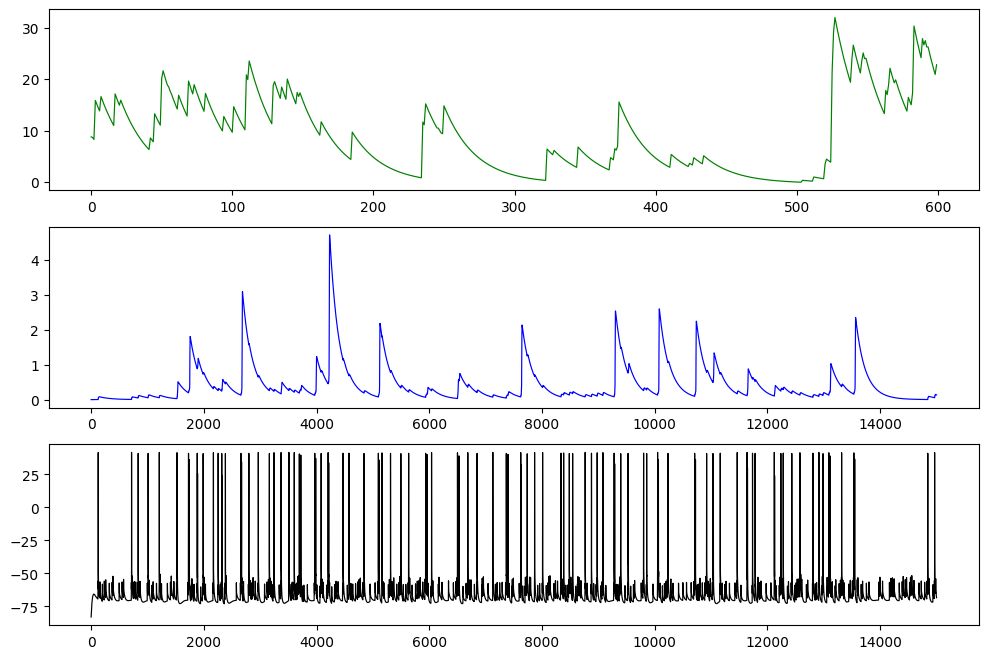

In [84]:
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(12,8))
i=10
ax1.plot(CaTrace[i][965:965+600]-np.min(CaTrace[i][965:965+600]),lw=0.86,c='green')
ax2.plot(t_vec,(calculate_dF_F(cai_soma)+calculate_dF_F(cai_tuft)),lw=0.86,c='blue')
ax3.plot(t_vec,v_soma,lw=0.86,c='black')
